# **Chapter 4: Transfer Learning And Other Tricks**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
transfer_model = models.resnet50(pretrained=True)

In [18]:
print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Freezing parameters**

In [19]:
for name, param in transfer_model.named_parameters():  # Замораживаем все веса, кроме слоев пакетной нормализации
    if("bn" not in name):
        param.requires_grad = False

# **Replacing the classifier**

In [20]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features,500),
    nn.ReLU(),                                 
    nn.Dropout(), 
    nn.Linear(500,2))

In [6]:
transfer_model.fc.in_features

2048

# **Training Again**

In [21]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="gpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [10]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "/content/drive/MyDrive/cats_vs_dogs_small/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)
val_data_path = "/content/drive/MyDrive/cats_vs_dogs_small/validation/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)

batch_size=64

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [11]:
print(len(val_data_loader.dataset))

2000


In [25]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [26]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 2.00, Validation Loss: 0.45, accuracy = 0.80
Epoch: 1, Training Loss: 0.41, Validation Loss: 0.43, accuracy = 0.83
Epoch: 2, Training Loss: 0.30, Validation Loss: 0.42, accuracy = 0.83
Epoch: 3, Training Loss: 0.25, Validation Loss: 0.42, accuracy = 0.84
Epoch: 4, Training Loss: 0.20, Validation Loss: 0.46, accuracy = 0.83
Epoch: 5, Training Loss: 0.15, Validation Loss: 0.55, accuracy = 0.84
Epoch: 6, Training Loss: 0.13, Validation Loss: 0.58, accuracy = 0.84
Epoch: 7, Training Loss: 0.11, Validation Loss: 0.57, accuracy = 0.83
Epoch: 8, Training Loss: 0.08, Validation Loss: 0.61, accuracy = 0.84
Epoch: 9, Training Loss: 0.06, Validation Loss: 0.77, accuracy = 0.84
Epoch: 10, Training Loss: 0.04, Validation Loss: 0.76, accuracy = 0.84
Epoch: 11, Training Loss: 0.06, Validation Loss: 0.75, accuracy = 0.84
Epoch: 12, Training Loss: 0.06, Validation Loss: 0.68, accuracy = 0.85
Epoch: 13, Training Loss: 0.04, Validation Loss: 0.77, accuracy = 0.84
Epoch: 14, Train

# LR Finder

In [23]:
import math
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="gpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

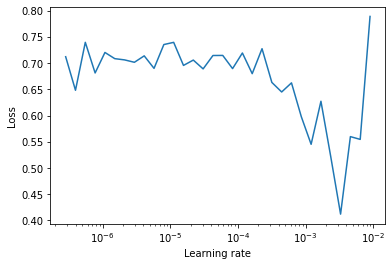

In [24]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

# **Дифференциальная скорость обучения**

In [27]:
transfer_model = models.resnet50(pretrained=True)

In [28]:
for name, param in transfer_model.named_parameters():  # Замораживаем все веса, кроме слоев пакетной нормализации
    if("bn" not in name):
        param.requires_grad = False

In [29]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features,500),
    nn.ReLU(),                                 
    nn.Dropout(), 
    nn.Linear(500,2))

Размораживаем 2 верхних слоя в серточной сети

In [31]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
  for param in layer.parameters():
    param.requires_grad = True

Задаем разные скорочти обучения для сверточных слоев и классификатора

In [33]:
found_lr = 0.001
transfer_model.to(device)
optimizer = optim.Adam([
{ 'params': transfer_model.layer4.parameters(), 'lr': found_lr /3},
{ 'params': transfer_model.layer3.parameters(), 'lr': found_lr /9},
], lr=found_lr)

In [34]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=10, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 0.39, Validation Loss: 0.27, accuracy = 0.88
Epoch: 1, Training Loss: 0.11, Validation Loss: 0.32, accuracy = 0.88
Epoch: 2, Training Loss: 0.05, Validation Loss: 0.41, accuracy = 0.86
Epoch: 3, Training Loss: 0.06, Validation Loss: 0.35, accuracy = 0.88
Epoch: 4, Training Loss: 0.03, Validation Loss: 0.36, accuracy = 0.88
Epoch: 5, Training Loss: 0.03, Validation Loss: 0.37, accuracy = 0.89
Epoch: 6, Training Loss: 0.02, Validation Loss: 0.35, accuracy = 0.89
Epoch: 7, Training Loss: 0.02, Validation Loss: 0.39, accuracy = 0.89
Epoch: 8, Training Loss: 0.03, Validation Loss: 0.38, accuracy = 0.89
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.35, accuracy = 0.88


In [35]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=10, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 0.01, Validation Loss: 0.39, accuracy = 0.89
Epoch: 1, Training Loss: 0.01, Validation Loss: 0.43, accuracy = 0.89
Epoch: 2, Training Loss: 0.02, Validation Loss: 0.39, accuracy = 0.89
Epoch: 3, Training Loss: 0.01, Validation Loss: 0.38, accuracy = 0.89
Epoch: 4, Training Loss: 0.01, Validation Loss: 0.42, accuracy = 0.89
Epoch: 5, Training Loss: 0.00, Validation Loss: 0.46, accuracy = 0.89
Epoch: 6, Training Loss: 0.00, Validation Loss: 0.48, accuracy = 0.88
Epoch: 7, Training Loss: 0.01, Validation Loss: 0.45, accuracy = 0.89
Epoch: 8, Training Loss: 0.02, Validation Loss: 0.39, accuracy = 0.89
Epoch: 9, Training Loss: 0.02, Validation Loss: 0.43, accuracy = 0.89


# Custom Transforms
Here we'll create a lambda transform and a custom transform class.

In [36]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output

In [37]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [38]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [ ]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [ ]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

# Ensembles
Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

In [ ]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

In [ ]:
avg_prediction

In [ ]:
torch.stack(predictions)